## 1 Data Preparation for Sentiment Classification of Mental Health

### 1.1 File load and train_val_test split

In [2]:
import collections
import numpy as np
import pandas as pd
import re
import random
import inspect
import os
from vaderSentiment import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from scipy.sparse import hstack
from argparse import Namespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier



[nltk_data] Downloading package punkt to /Users/luhui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luhui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luhui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/luhui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
args = Namespace(                                 # Create key, value pairs, and access values later on, e.g., args.seed
    input_dataset_csv="data/Combined Data.csv",
    train_proportion=0.7,
    test_proportion=0.3,
    seed=6312
)

In [4]:
# Read raw data
df = pd.read_csv(args.input_dataset_csv, header=0, names=['No', 'statement', 'status']) # no header in the file

In [5]:
df.head()

,No,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
#Extract and reorder necessary columns
df = df[['status', 'statement']]

In [7]:
# remove all the rows with null
df = df[df.statement.isna() == False]
df = df[df.status.isna() == False]
df.isna().value_counts()

status  statement
False   False        52681
Name: count, dtype: int64

In [8]:
# check the distribution of label
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [9]:
# groups rows from dataframe by status to dictionary
by_status = collections.defaultdict(list)
for _, row in df.iterrows():
    by_status[row.status].append(row.to_dict())

# by_status will be like below:
#  {
#   'Anxiety' : [{'Anxiety': [{'status': 'Anxiety', 'statement': 'oh my gosh'},{'status': 'Anxiety','statement': 'trouble sleeping, confused mind, restless heart. All out of tune'}, ...... ], 
#   'Normal' : [{'status': 'Normal','statement': 'Gr gr dreaming of ex crush to be my game, God'}, {'status': 'Normal', 'statement': 'wkwkwk what a joke'}, ...... ],
#   ......
#   'Personality disorder' : {'status': 'Personality disorder','statement': "Is there anyone interested in joining a group ..... "}, {'status': 'Personality disorder','statement': "Anyone else have nothing in common with other people? ....."},

#  }

In [10]:
# split dateset to train, validate and test dataset and stored in list
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_status.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list) 

In [11]:
# switch split data list to dataframe
final_df = pd.DataFrame(final_list)
final_df.split.value_counts()

split
train    36872
test     15802
Name: count, dtype: int64

### 1.2 Data preprocessing

#### Remove URL, @ ,punctuation and any other special characters from statements

In [12]:
def clean_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s.?!,]', '', text)

    text = re.sub(r"([.,!?])", r" \1 ", text)  # E.g., convert "end." to "end . " ; \1 indicates a matched character

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if not word in stop_words])
    
    return text.strip()
    
final_df.statement = final_df.statement.apply(clean_text)
final_df.head()


,status,statement,split
0,Anxiety,"crazy bloating hi everyone , ive pretty much h...",train
1,Anxiety,"bipolar relapse welcome shortness breath , tre...",train
2,Anxiety,"eye dropping sharp pain behind eye , also head...",train
3,Anxiety,really scared diabetes major hypochondriac . m...,train
4,Anxiety,live moment stop worrying changing relationshi...,train


#### Tokenization

In [13]:
final_df['tokened_word'] = final_df.statement.apply(lambda x: re.sub(r'[.,!?]+', '', x).strip())
final_df['tokened_word'] = final_df.tokened_word.apply(word_tokenize)
final_df.head()

,status,statement,split,tokened_word
0,Anxiety,"crazy bloating hi everyone , ive pretty much h...",train,"[crazy, bloating, hi, everyone, ive, pretty, m..."
1,Anxiety,"bipolar relapse welcome shortness breath , tre...",train,"[bipolar, relapse, welcome, shortness, breath,..."
2,Anxiety,"eye dropping sharp pain behind eye , also head...",train,"[eye, dropping, sharp, pain, behind, eye, also..."
3,Anxiety,really scared diabetes major hypochondriac . m...,train,"[really, scared, diabetes, major, hypochondria..."
4,Anxiety,live moment stop worrying changing relationshi...,train,"[live, moment, stop, worrying, changing, relat..."


#### Add new feature (word length)

In [14]:
final_df['word_length'] = final_df['tokened_word'].apply(lambda x: len(x))

#### Add new feature (sentiment scores)
calculates the negative, neutral, positive, and overall (compound) sentiment scores 

In [15]:
analyzer = SentimentIntensityAnalyzer()

final_df['score_neg']  = final_df['statement'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
final_df['score_neu']  = final_df['statement'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
final_df['score_pos']  = final_df['statement'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
final_df['score_compound']  = final_df['statement'].apply(lambda x: analyzer.polarity_scores(x)['compound'])



In [16]:
# compare the average overall sentiment across different mental health status groups
print(final_df[final_df['status'] == 'Suicidal'].score_compound.mean())
print(final_df[final_df['status'] == 'Bipolar'].score_compound.mean())
print(final_df[final_df['status'] == 'Depression'].score_compound.mean())
print(final_df[final_df['status'] == 'Personality disorder'].score_compound.mean())
print(final_df[final_df['status'] == 'Anxiety'].score_compound.mean())
print(final_df[final_df['status'] == 'Normal'].score_compound.mean())



-0.3569980473150582
-0.07001930140439323
-0.2378252791482732
-0.038748653667595175
-0.3324285602707628
0.11121266597319954


#### Remove stop words

In [17]:
def remove_stopwords(word_list):
    stop_words = set(stopwords.words('english'))
    word_list = [word for word in word_list if not word in stop_words]
    return word_list

final_df.tokened_word = final_df.tokened_word.apply(remove_stopwords)

#### Stemming and Lemming

In [18]:
def stem_words(word_list):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    word_list = [stemmer.stem(word) for word in word_list]
    return word_list

def lemmatize_verbs(word_list):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    word_list = [lemmatizer.lemmatize(word, pos='v') for word in word_list]
    return word_list

final_df['stemmed_word'] = final_df.tokened_word.apply(stem_words)
final_df['stemmed_word'] = final_df.tokened_word.apply(lemmatize_verbs)

final_df.head()


,status,statement,split,tokened_word,word_length,score_neg,score_neu,score_pos,score_compound,stemmed_word
0,Anxiety,"crazy bloating hi everyone , ive pretty much h...",train,"[crazy, bloating, hi, everyone, ive, pretty, m...",76,0.290,0.580,0.130,-0.9538,"[crazy, bloat, hi, everyone, ive, pretty, much..."
1,Anxiety,"bipolar relapse welcome shortness breath , tre...",train,"[bipolar, relapse, welcome, shortness, breath,...",10,0.259,0.582,0.159,-0.2263,"[bipolar, relapse, welcome, shortness, breath,..."
2,Anxiety,"eye dropping sharp pain behind eye , also head...",train,"[eye, dropping, sharp, pain, behind, eye, also...",20,0.221,0.635,0.144,-0.3954,"[eye, drop, sharp, pain, behind, eye, also, he..."
3,Anxiety,really scared diabetes major hypochondriac . m...,train,"[really, scared, diabetes, major, hypochondria...",45,0.336,0.664,0.000,-0.9627,"[really, scar, diabetes, major, hypochondriac,..."
4,Anxiety,live moment stop worrying changing relationshi...,train,"[live, moment, stop, worrying, changing, relat...",46,0.155,0.534,0.311,0.9183,"[live, moment, stop, worry, change, relationsh..."


## 2 EDA

In [19]:
df_eda = final_df.copy()

In [20]:

# Get the installation path of the vaderSentiment module
def load_vader_lexicon():
    """Load sentiment lexicon from VADER package"""
    vader_path = os.path.dirname(inspect.getfile(vaderSentiment))
    lexicon_file_path = os.path.join(vader_path, 'vader_lexicon.txt')
    
    vader_lexicon = {}
    with open(lexicon_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                word = parts[0]
                score = float(parts[1])
                vader_lexicon[word] = score
    return vader_lexicon

def filter_words(tokens, lexicon, threshold=0.5):
    """
    Select tokens whose absolute VADER score exceeds threshold.
    
    Args:
        tokens (list): list of token strings
        lexicon (dict): VADER sentiment lexicon
        threshold (int): sentiment score threshold
    
    Returns:
        list: filtered tokens
    """
    filtered_words = []
    for word in tokens:
        if word in lexicon:
            score = lexicon[word]
            if abs(score) > threshold:
                filtered_words.append(word)
    return filtered_words

vader_lexicon = load_vader_lexicon()
df_eda['important_word'] = df_eda['tokened_word'].apply(lambda x: filter_words(x, vader_lexicon))


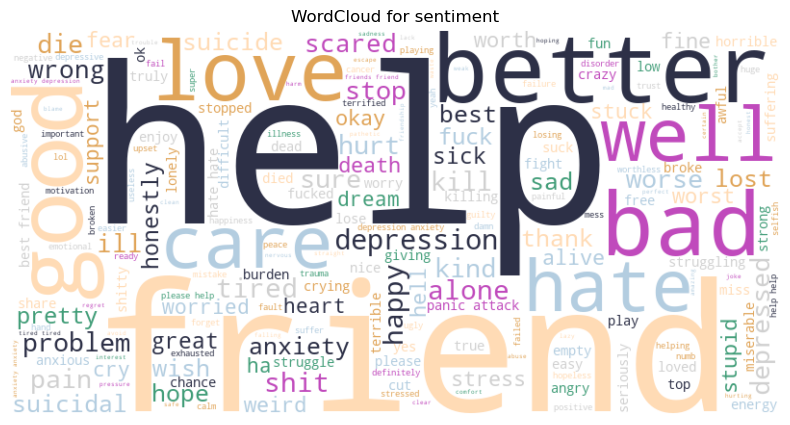

In [21]:
# Get unique categories in 'status'
statuses = df_eda['status'].unique()
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']
# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

tokens_data = ' '.join(df_eda['important_word'].apply(lambda x: ' '.join(x)))
# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title(f'WordCloud for sentiment')
plt.show()


# # Generate and plot the WordCloud for each category
# for status in statuses:
#     # Filter the tokens data for the current status
#     tokens_data = ' '.join(df_eda[df_eda['status'] == status]['important_word'].apply(lambda x: ' '.join(x)))
#     # Generate the WordCloud
#     wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
#     # Plot the WordCloud
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')  # Turn off axis
#     plt.title(f'WordCloud for Status: {status}')
#     plt.show()

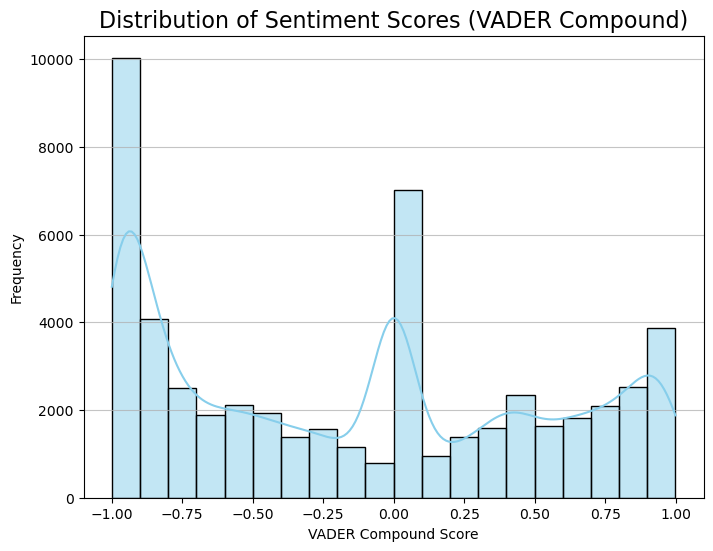

In [22]:


plt.figure(figsize=(8, 6))
sns.histplot(df_eda['score_compound'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores (VADER Compound)', fontsize=16)
plt.xlabel('VADER Compound Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

/var/folders/6w/dc0f1xpd3bs4_rlqgymllpww0000gn/T/ipykernel_85020/3265831109.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_eda['status'], y=df_eda['score_compound'], data=df_eda, palette='viridis')


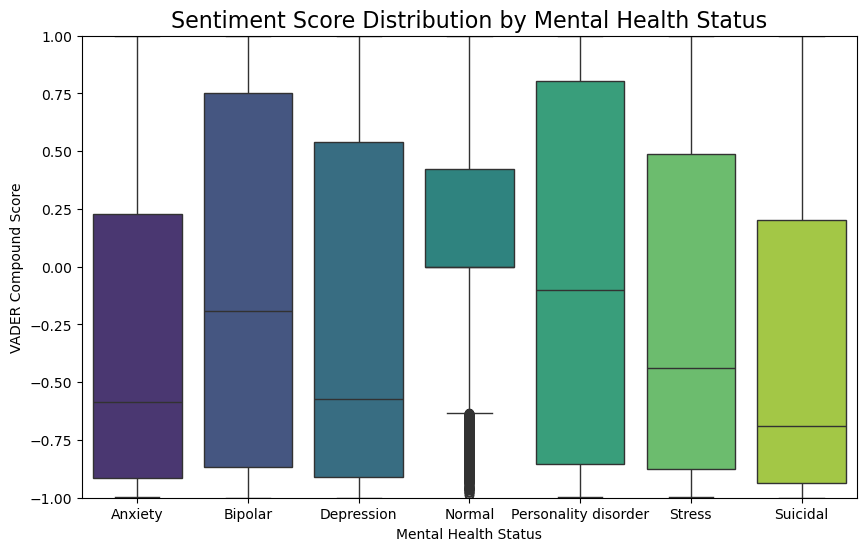

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_eda['status'], y=df_eda['score_compound'], data=df_eda, palette='viridis')
plt.title('Sentiment Score Distribution by Mental Health Status', fontsize=16)
plt.xlabel('Mental Health Status')
plt.ylabel('VADER Compound Score')
plt.ylim(-1, 1)  
plt.show()

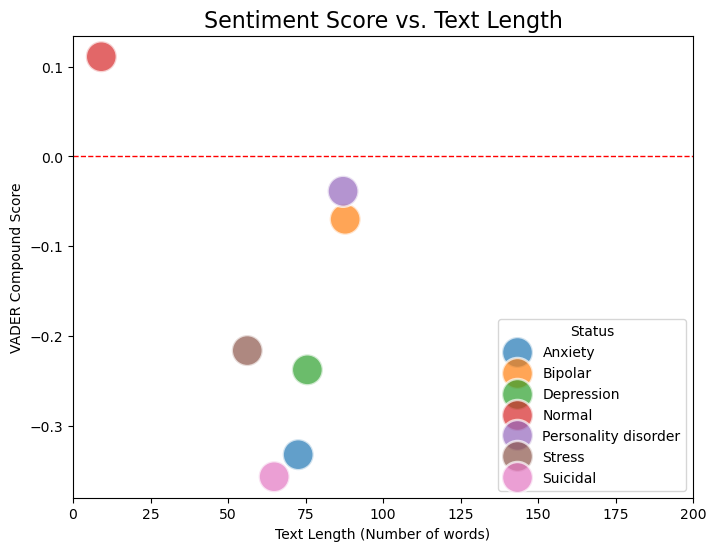

In [24]:
df_sub = df_eda.groupby('status', as_index = False).agg(
    avg_word_length = ('word_length', 'mean'),
    avg_score_compound = ('score_compound', 'mean')
)

df_sub

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_sub['avg_word_length'], y=df_sub['avg_score_compound'], data=df_sub, s=500, alpha=0.7, hue='status', palette='tab10')
plt.title('Sentiment Score vs. Text Length', fontsize=16)
plt.xlabel('Text Length (Number of words)')
plt.ylabel('VADER Compound Score')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1) # Reference line at 0 sentiment
plt.xlim(0,200) 
plt.legend(title='Status')
plt.show()

## 3 Machine Learning

### 3.1 Sentiment Status Classification

In [25]:
df_ml = final_df.copy()

# Use a LabelEncoder to convert the categorical status column into numerical labels
lbl_enc = LabelEncoder()
df_ml['status'] = lbl_enc.fit_transform(df_ml['status'].values)


# Create a dictionary to store the mapping between the new numerical codes and the original text labels.
original_labels = lbl_enc.classes_
encoded_labels = np.arange(len(original_labels))

zipped_pairs = zip(encoded_labels, original_labels)
label_map = dict(zipped_pairs)

label_map

{np.int64(0): 'Anxiety',
 np.int64(1): 'Bipolar',
 np.int64(2): 'Depression',
 np.int64(3): 'Normal',
 np.int64(4): 'Personality disorder',
 np.int64(5): 'Stress',
 np.int64(6): 'Suicidal'}

In [26]:
#TF-IDF Vectors as features
#Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

train_x = df_ml[df_ml['split'] == 'train'][['stemmed_word','word_length', 'score_compound', 'score_neg', 'score_pos', 'score_neu']]
train_y = df_ml[df_ml['split'] == 'train']['status']
test_x = df_ml[df_ml['split'] == 'test'][['stemmed_word','word_length','score_compound', 'score_neg', 'score_pos', 'score_neu']]
test_y = df_ml[df_ml['split'] == 'test']['status']


tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(train_x['stemmed_word'].apply(lambda x: ' '.join(x)))
xtest_tfidf =  tfidf_vect.transform(test_x['stemmed_word'].apply(lambda x: ' '.join(x)))

#combine all the features
X_train_combined = hstack([xtrain_tfidf,train_x[['word_length', 'score_compound', 'score_neg', 'score_pos', 'score_neu']].values])
X_test_combined = hstack([xtest_tfidf,test_x[['word_length', 'score_compound', 'score_neg', 'score_pos', 'score_neu']].values])


In [27]:
# Apply the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to the training data
# Address class imbalance by generating synthetic samples for minority classes

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, train_y)
y_train_resampled.value_counts()



status
0    11440
1    11440
2    11440
3    11440
4    11440
5    11440
6    11440
Name: count, dtype: int64

In [28]:
text_y_decode = [label_map[i] for i in test_y]
class_name = list(label_map.values())
class_name

['Anxiety',
 'Bipolar',
 'Depression',
 'Normal',
 'Personality disorder',
 'Stress',
 'Suicidal']

In [29]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    """
    Train model and return validation accuracy.
    """
    # Fit model
    model = classifier.fit(feature_vector_train, label_train)
    
    # Predict on validation set
    predictions = model.predict(feature_vector_valid)
    
    # Compute accuracy
    accuracy = metrics.accuracy_score(label_valid, predictions)
    
    return accuracy, predictions, model

# Define classic ML classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200),
    'XGBoost': XGBClassifier(random_state=42,scale_pos_weight='balanced',use_label_encoder=False,eval_metric='logloss',n_estimators = 200)
}



In [30]:
# iterate through a dictionary of classifiers and store the result in a dictionary
result = {}
for name, clf in classifiers.items():
    accuracy, predictions,model = train_model(clf, X_train_resampled, y_train_resampled, X_test_combined, test_y)
    result[name] = {
        'accuracy' : accuracy,
        'predictions' : predictions,
        'model': model
    }

/opt/anaconda3/envs/mental_health_analysis_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/opt/anaconda3/envs/mental_health_analysis_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:12:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- LogisticRegression ---
Accuracy: 0.7338
                      precision    recall  f1-score   support

             Anxiety       0.76      0.79      0.77      1152
             Bipolar       0.75      0.77      0.76       833
          Depression       0.71      0.63      0.67      4621
              Normal       0.87      0.90      0.89      4902
Personality disorder       0.61      0.64      0.62       323
              Stress       0.49      0.57      0.52       776
            Suicidal       0.62      0.65      0.63      3195

            accuracy                           0.73     15802
           macro avg       0.69      0.71      0.70     15802
        weighted avg       0.73      0.73      0.73     15802


--- Decision Tree ---
Accuracy: 0.6324
                      precision    recall  f1-score   support

             Anxiety       0.60      0.50      0.55      1152
             Bipolar       0.91      0.45      0.60       833
          Depression       0.57      0.69  

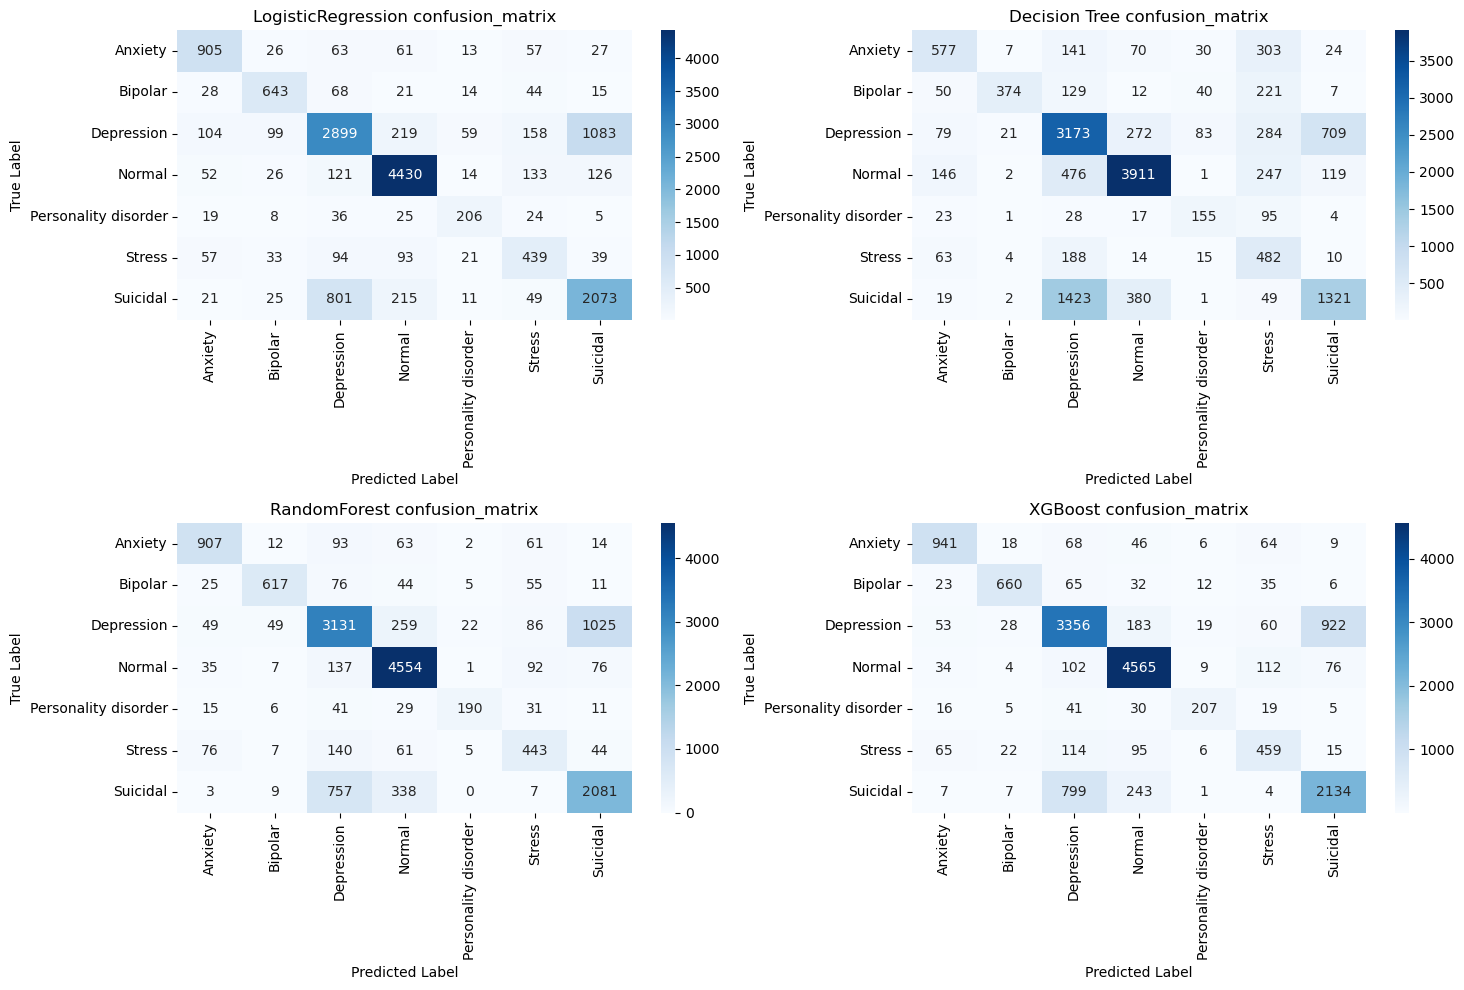

In [31]:
 # Set overall figure size
plt.figure(figsize=(15, 10))

for i, (name, model_result) in enumerate(result.items()):
    accuracy = model_result['accuracy']
    predictions = model_result['predictions']
    predictions_decode = [label_map[i] for i in predictions]
    report = classification_report(text_y_decode, predictions_decode, target_names=class_name, digits=2)
    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(report)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(text_y_decode, predictions_decode)
    
    # Plot confusion matrix heatmap
    plt.subplot(2, 2, i + 1)  # subplot grid 2x2, position i+1
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_name, yticklabels=class_name)
    plt.title(f'{name} confusion_matrix', fontsize=12)
    plt.ylabel('True Label', fontsize=10)
    plt.xlabel('Predicted Label', fontsize=10)


plt.tight_layout() # Adjust layout to avoid overlap
plt.show() # Show all plots

print("=" * 50)


/var/folders/6w/dc0f1xpd3bs4_rlqgymllpww0000gn/T/ipykernel_85020/1071557932.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')


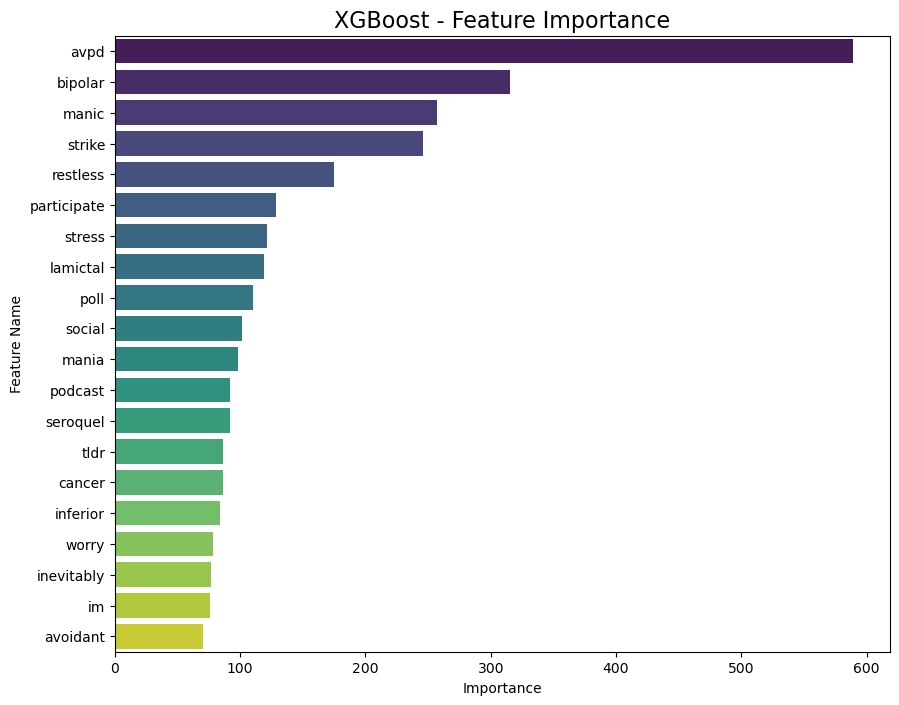

In [32]:
# extract XGBoost Model from result dictionary
XGB_model = result['XGBoost']['model']

# extract feature names and feature importance 
importance_scores = XGB_model.get_booster().get_score(importance_type='gain')
tfidf_names = list(tfidf_vect.get_feature_names_out())
manual_feature_names = [
    'word_length',
    'score_compound', 
    'score_neg', 
    'score_pos', 
    'score_neu'
]

feature_names = tfidf_names + manual_feature_names

# Convert to DataFrame for easier processing
import pandas as pd
feature_df = pd.DataFrame(
    list(importance_scores.items()), 
    columns=['Feature', 'Importance']
)
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(20)

def map_feature_name(f_index):
    # f_index pattern: 'f0', 'f1', ...
    index = int(f_index[1:])
    return feature_names[index]

feature_df['Feature Name'] = feature_df['Feature'].apply(map_feature_name)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')
plt.title("XGBoost - Feature Importance" \
"", fontsize=16)
plt.show()

### 3.2 Sentiment Clustering

In [93]:
df_km  = final_df.copy()
df_km.head()
df_km['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [94]:
df_km['pos_tag'] = df_km['stemmed_word'].apply(nltk.pos_tag)
df_km['stemmed_word'] = df_km['stemmed_word'].apply(lambda x: ' '.join(x))

df_km.head()

,status,statement,split,tokened_word,word_length,score_neg,score_neu,score_pos,score_compound,stemmed_word,pos_tag
0,Anxiety,"crazy bloating hi everyone , ive pretty much h...",train,"[crazy, bloating, hi, everyone, ive, pretty, m...",76,0.290,0.580,0.130,-0.9538,crazy bloat hi everyone ive pretty much health...,"[(crazy, JJ), (bloat, NN), (hi, NN), (everyone..."
1,Anxiety,"bipolar relapse welcome shortness breath , tre...",train,"[bipolar, relapse, welcome, shortness, breath,...",10,0.259,0.582,0.159,-0.2263,bipolar relapse welcome shortness breath tremo...,"[(bipolar, JJ), (relapse, NN), (welcome, JJ), ..."
2,Anxiety,"eye dropping sharp pain behind eye , also head...",train,"[eye, dropping, sharp, pain, behind, eye, also...",20,0.221,0.635,0.144,-0.3954,eye drop sharp pain behind eye also head ache ...,"[(eye, NN), (drop, NN), (sharp, JJ), (pain, NN..."
3,Anxiety,really scared diabetes major hypochondriac . m...,train,"[really, scared, diabetes, major, hypochondria...",45,0.336,0.664,0.000,-0.9627,really scar diabetes major hypochondriac morni...,"[(really, RB), (scar, VB), (diabetes, NNS), (m..."
4,Anxiety,live moment stop worrying changing relationshi...,train,"[live, moment, stop, worrying, changing, relat...",46,0.155,0.534,0.311,0.9183,live moment stop worry change relationship anx...,"[(live, JJ), (moment, NN), (stop, NN), (worry,..."


In [111]:
df_km['noun'] = df_km['pos_tag'].apply(lambda x: [word for word, pos in x if pos.startswith('N')])
df_km['noun'] = df_km['noun'].apply(lambda x: filter_words(x, vader_lexicon))

In [97]:
# vectorize the text data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_km['stemmed_word'])
y = df_km['status']

In [68]:
# Address class imbalance by generating synthetic samples for minority classes
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts()

status
Anxiety                 16343
Bipolar                 16343
Depression              16343
Normal                  16343
Personality disorder    16343
Stress                  16343
Suicidal                16343
Name: count, dtype: int64

In [69]:
# perform K-Means clustering with 3 clusters 
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_resampled)

In [38]:

# calculate the Silhouette Score to evaluate the clustering quality

score = silhouette_score(X_resampled, clusters)
print(f'Silhouette Score: {score}')


Silhouette Score: -0.005684311021559125


Cluster sizes:
Cluster 0: 26447 documents
Cluster 1: 58087 documents
Cluster 2: 29867 documents


/var/folders/6w/dc0f1xpd3bs4_rlqgymllpww0000gn/T/ipykernel_85020/3263095999.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral', len(unique_labels))


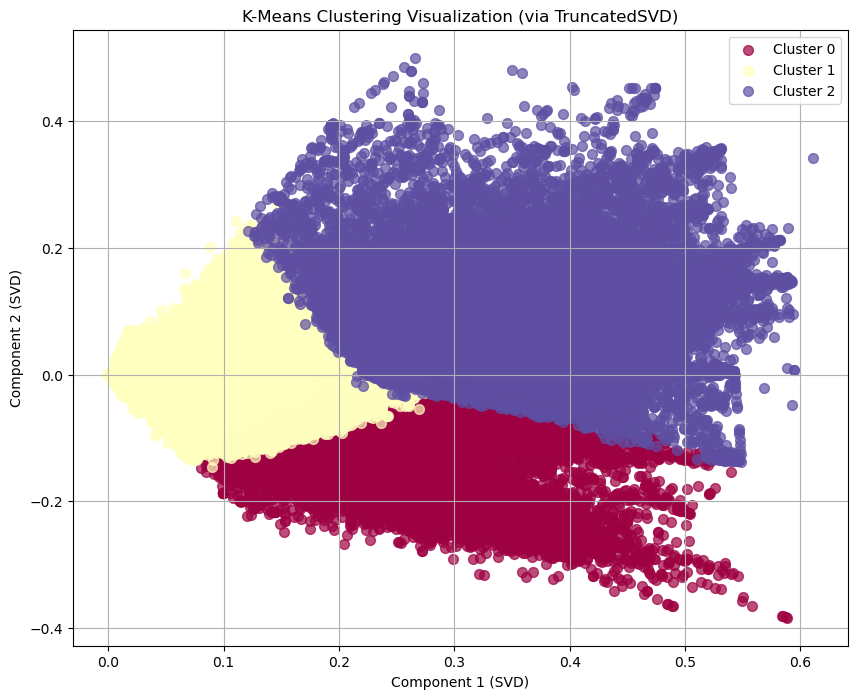

In [112]:
# Attach cluster results back to the original DataFrame
df_km['cluster_label'] = clusters[:len(df_km)]

# Print size of each cluster
print("Cluster sizes:")
unique_labels, counts = np.unique(clusters, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} documents")


# --- Core visualization steps ---

# 1. Reduce to 2D using TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
reduced_data = svd.fit_transform(X_resampled)


# 2. Create a color map, one color per cluster
unique_labels = np.unique(clusters)
colors = plt.cm.get_cmap('Spectral', len(unique_labels))

# 3. Draw scatter plot
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    # Find all points for the current cluster
    indices = clusters == label
    plt.scatter(
        reduced_data[indices, 0], 
        reduced_data[indices, 1], 
        label=f'Cluster {label}',
        color=colors(i),
        alpha=0.7,
        s=50
    )

plt.title('K-Means Clustering Visualization (via TruncatedSVD)')
plt.xlabel('Component 1 (SVD)')
plt.ylabel('Component 2 (SVD)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
print('high:', '\n', df_km[df_km['cluster_label'] == 0]['status'].value_counts())
print('avg:', '\n', df_km[df_km['cluster_label'] == 2]['status'].value_counts())
print('low:', '\n', df_km[df_km['cluster_label'] == 1]['status'].value_counts())

high: 
 status
Depression              9122
Suicidal                6666
Stress                   329
Bipolar                  327
Normal                   309
Anxiety                  260
Personality disorder     216
Name: count, dtype: int64
avg: 
 status
Anxiety                 1228
Bipolar                 1120
Depression               703
Stress                   702
Personality disorder     454
Normal                   422
Suicidal                  34
Name: count, dtype: int64
low: 
 status
Normal                  15612
Depression               5579
Suicidal                 3952
Anxiety                  2353
Stress                   1556
Bipolar                  1330
Personality disorder      407
Name: count, dtype: int64


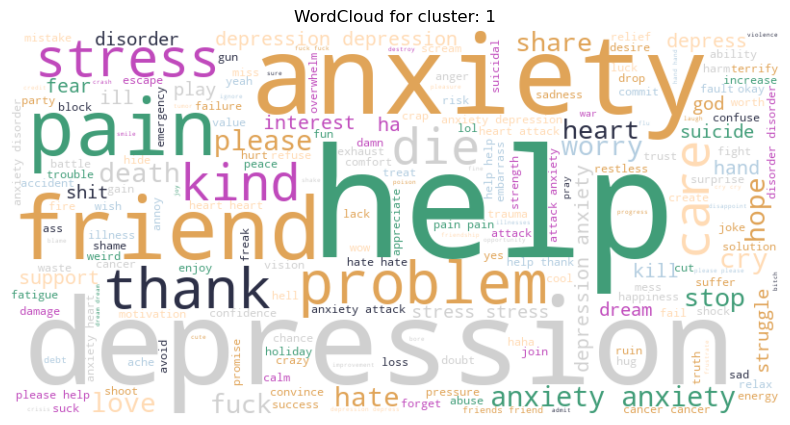

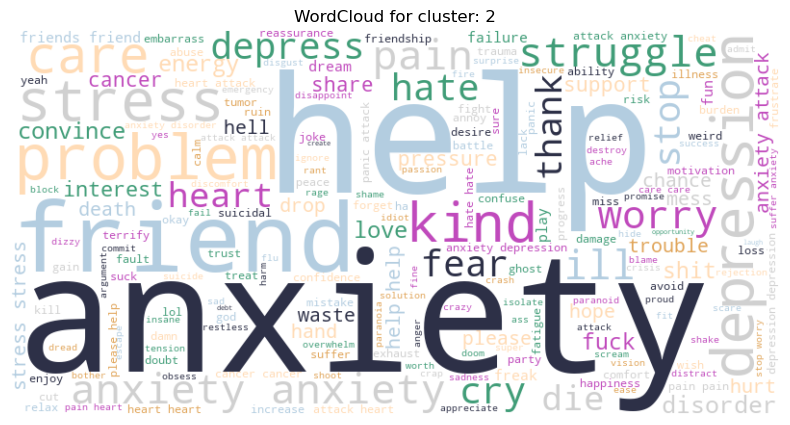

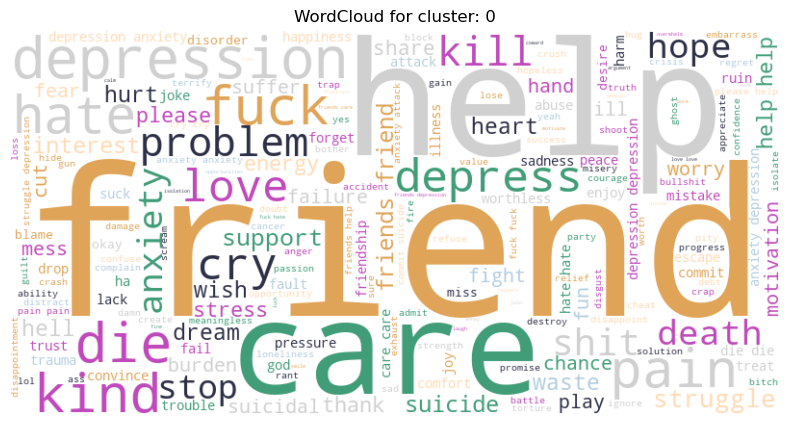

In [116]:
# Get unique categories in 'status'
cluster_labels = df_km['cluster_label'].unique()
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']
# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for cluster_label in cluster_labels:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df_km[(df_km['cluster_label']) == cluster_label]['noun'].apply(lambda x: ' '.join(x)))
    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for cluster: {cluster_label}')
    plt.show()